# [Sweatpants Unleashed — the Data Science of an Ignominious Garment](https://towardsdatascience.com/sweatpants-unleashed-the-data-science-of-an-ignominious-garment-2e0c006202b0)

## A Time Serie Analysis of How Covid-19 Unraveled a Loose Attire

We will run a SARIMA model and its diagnostics, with KPSS, ADF, OCSB, CH, and normality tests. Step by step, with Python, at the frayed seams of civilization.


*“Sweatpants are a sign of defeat. You lost control of your life so you bought some sweatpants.”* Karl Lagerfeld

We are going to analyze the monthly Google Trends data for the keyword “sweatpants” from 2010 through 2021 September; and will then investigate which new insights on the course of history and human civilization we can extract.


(PSA: Doom is nigh!)


[sweatpants — Explore — Google Trends](https://trends.google.com/trends/explore?date=2010-08-25%202021-09-25&q=sweatpants)

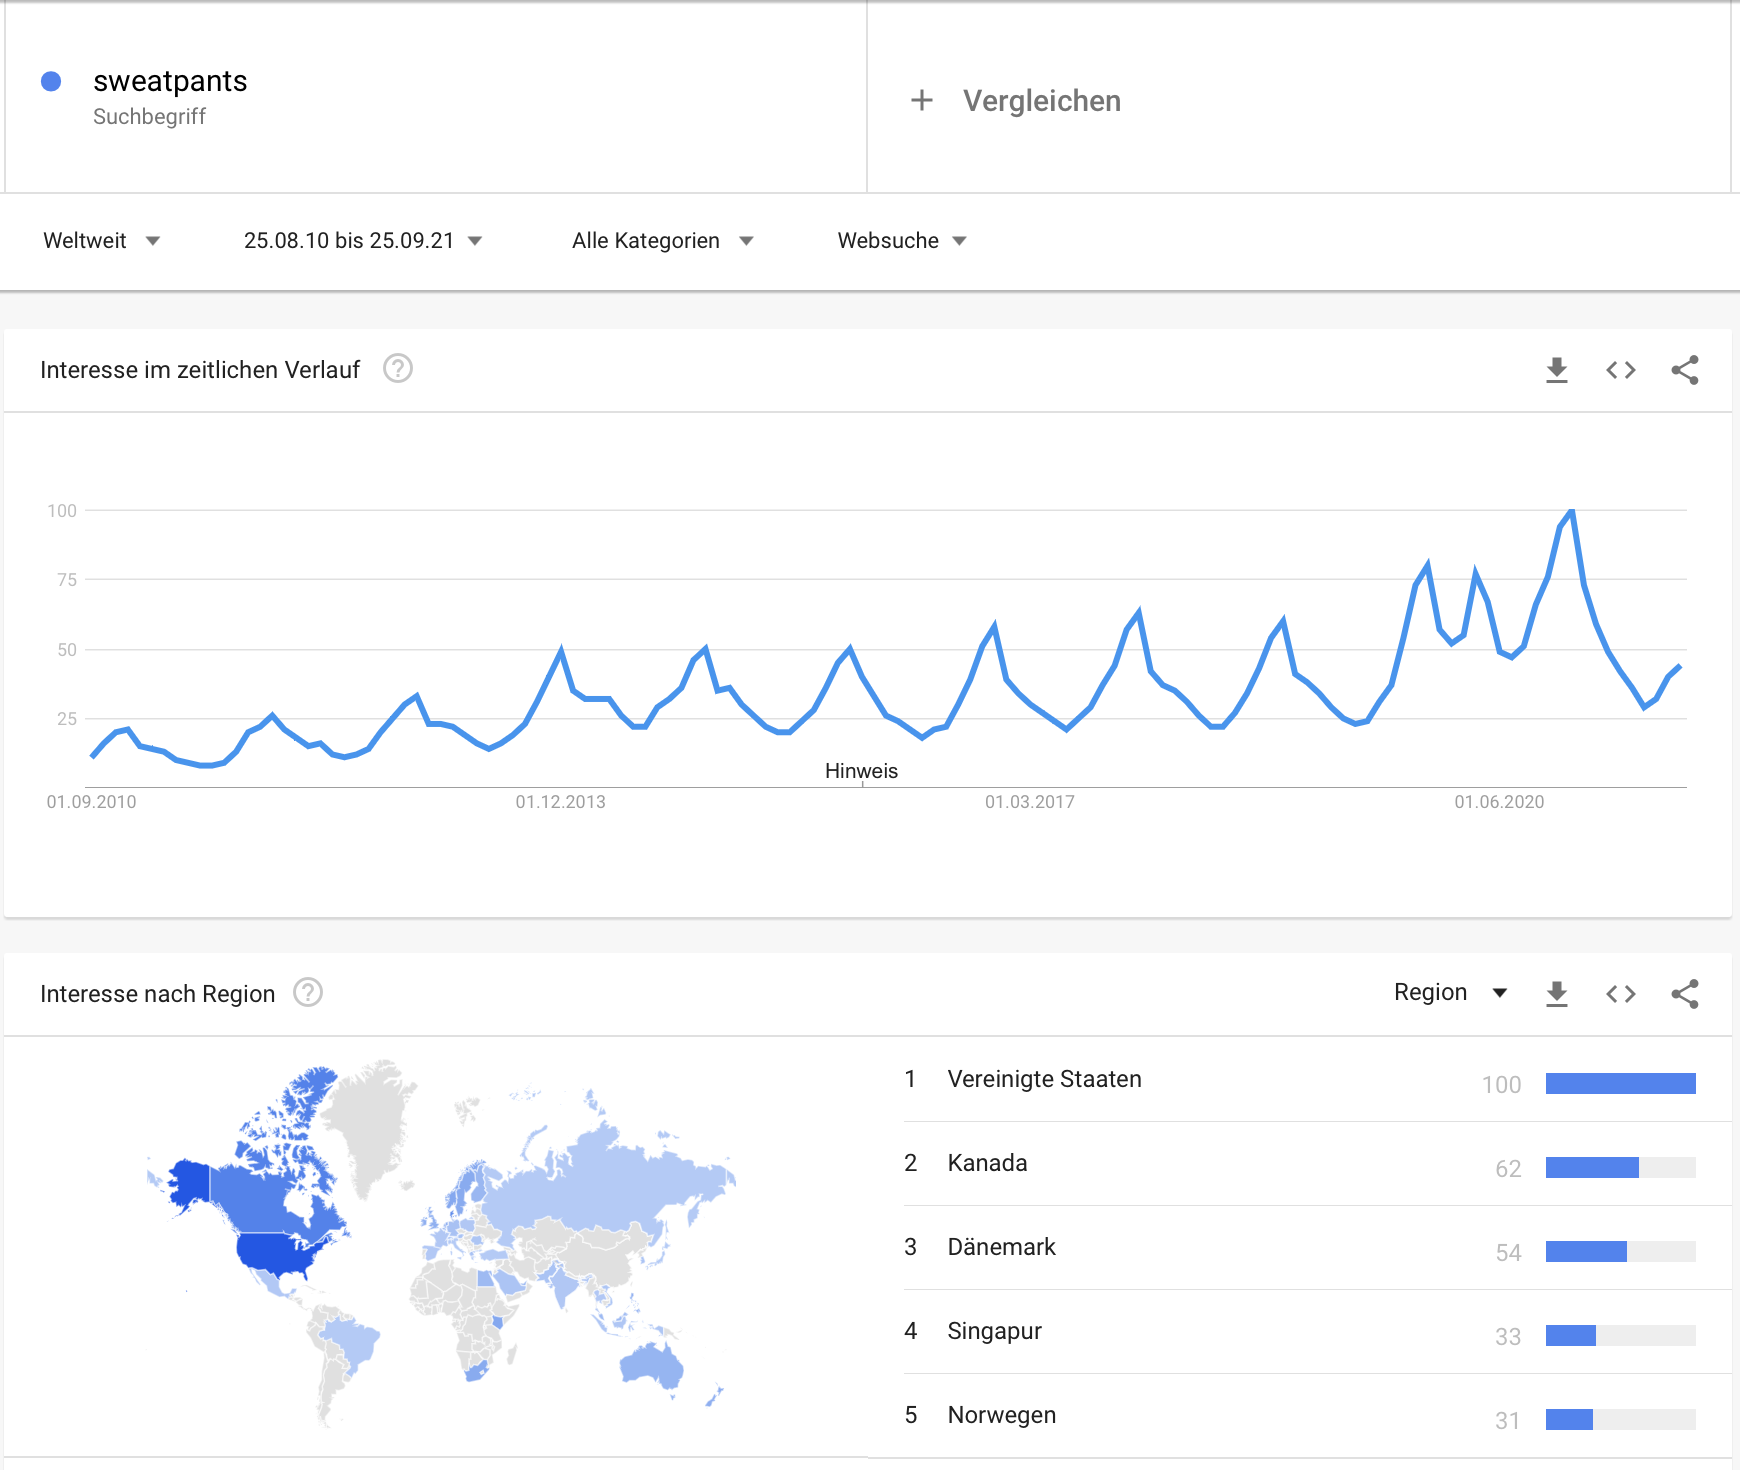

In [12]:
from IPython.display import Image
Image('images/google_trends_sweatpants.png')

## 0. Dependencies

In [2]:
# dependencies

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdat
import seaborn as sns

import pmdarima as pmd

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import normaltest

import warnings
import sys


ALPHA = 0.05                            # significance level
MSEAS = 12                              # seasonality
TESTP = 24                              # months to reserve for test dataset

warnings.filterwarnings("ignore")

## 1. Data Processing

### 1.1 Reading and Wrangling

After downloading the pants.csv file from Google Trends, we read it into the Jupyter notebook.

In [6]:
# read the source data file

df = pd.read_csv("data/pants_multiTimeline.csv")
df

,Monat,sweatpants: (Weltweit)
0,2010-09,11
1,2010-10,16
2,2010-11,20
3,2010-12,21
4,2011-01,15
...,...,...
128,2021-05,36
129,2021-06,29
130,2021-07,32
131,2021-08,40


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Monat                   133 non-null    object
 1   sweatpants: (Weltweit)  133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


The “Month” column has been imported as an object/string, therefore we convert it to datetime and then define an index.

In [8]:
# convert objects/strings to datetime and numbers; set datetime index

df = df.dropna()
df.columns = ["Date", "Pants"]              # rename columns
df.Date = df["Date"]      
df.Date = pd.to_datetime(df.Date)           # convert imported object/string to datetime
df.set_index(df.Date, inplace=True)         # set Date as index
df["year"] = df.index.year
df["month"] = df.index.month
df = df.sort_index(axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2010-09-01 to 2021-09-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    133 non-null    datetime64[ns]
 1   Pants   133 non-null    int64         
 2   year    133 non-null    int64         
 3   month   133 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.2 KB


We limit our analysis to the ups and downs of the sweatpants vogue since 2010.

In [10]:
# limit to > 2010
df = df.loc[df['year'] > 2010]
y = pd.Series(df['Pants'])
df

,Date,Pants,year,month
Date,,,,
2011-01-01,2011-01-01,15,2011,1
2011-02-01,2011-02-01,14,2011,2
2011-03-01,2011-03-01,13,2011,3
2011-04-01,2011-04-01,10,2011,4
2011-05-01,2011-05-01,9,2011,5
...,...,...,...,...
2021-05-01,2021-05-01,36,2021,5
2021-06-01,2021-06-01,29,2021,6
2021-07-01,2021-07-01,32,2021,7


Now we are ready to sit down and start some serious data wrangling to learn what the sweatpants fashion cycle is made of.

### 1.2 Visual Analysis

#### 1.2a Chart the Raw Data

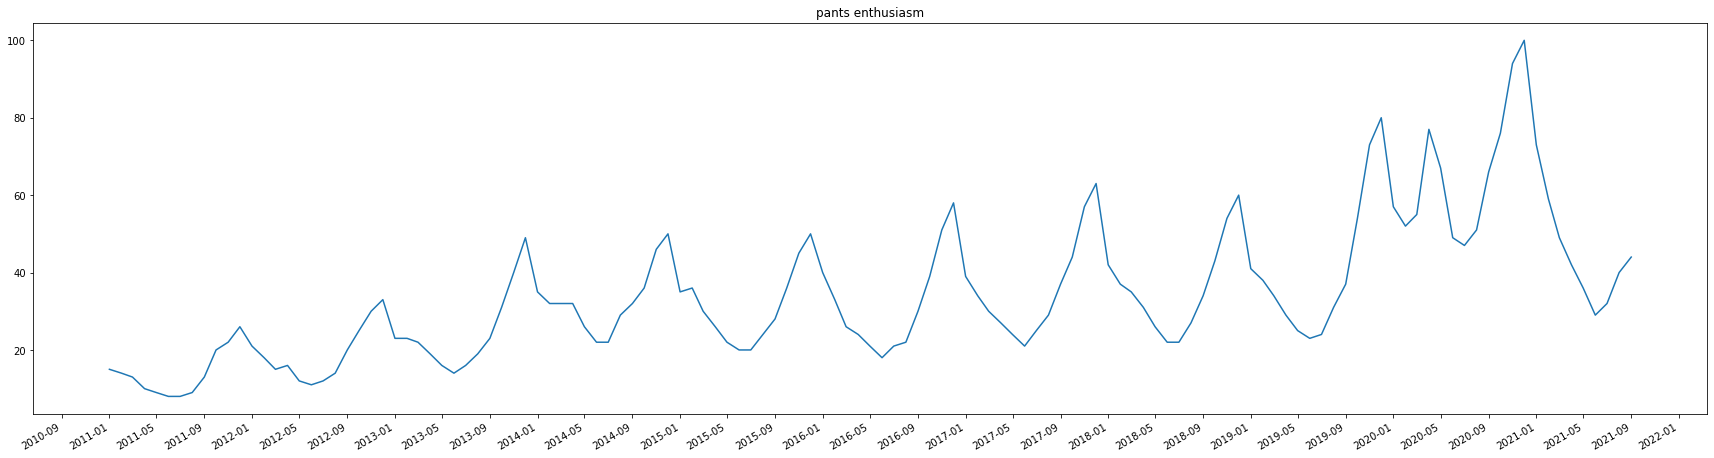

In [13]:
# plot the sweatpants fashion trend

figure = plt.figure()
plt.title('pants enthusiasm')
plt.gcf().set_size_inches(30, 8)
plt.plot(df['Date'], y)
ax = plt.gca()
ax.xaxis.set_major_locator(mdat.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdat.DateFormatter('%Y-%m'))
# _=plt.xticks(rotation=45)   
plt.gcf().autofmt_xdate()           # auto rotation
plt.show()

We observe a rising long-term trend. Civilization has undeniably been drifting towards a cliff edge for the past decade.


We see stable seasonal fluctuations — stable until recently. The pattern indicates a single peak and trough in every year.


We also perceive a funnel-shaped pattern of fluctuations. The peaks and dips exhibit higher amplitudes towards the end of the timeline. This suggests heteroskedasticity: the variance is not time-invariant.

#### 1.2b Outliers, Heatmap, Trend, and Seasonality


We will create a pivot table, from which we will derive a couple of charts that will enable us to focus on different aspects of the time series.


The pivot table provides us with a nifty way to aggregate, sort and filter the source data.

In [14]:
# pivot table

pivot = pd.pivot_table(
    df, values='Pants', index='month', columns='year', 
    aggfunc='mean', margins=False, margins_name="Avg", fill_value=0)
pivot.transpose()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2011,15,14,13,10,9,8,8,9,13,20,22,26
2012,21,18,15,16,12,11,12,14,20,25,30,33
2013,23,23,22,19,16,14,16,19,23,31,40,49
2014,35,32,32,32,26,22,22,29,32,36,46,50
2015,35,36,30,26,22,20,20,24,28,36,45,50
2016,40,33,26,24,21,18,21,22,30,39,51,58
2017,39,34,30,27,24,21,25,29,37,44,57,63
2018,42,37,35,31,26,22,22,27,34,43,54,60
2019,41,38,34,29,25,23,24,31,37,54,73,80


The pivot table indicates that the popularity of sweatpants tends to soar near year-ends. Let’s visualize the hot zones for loose pants in a heatmap.

<AxesSubplot:xlabel='month', ylabel='year'>

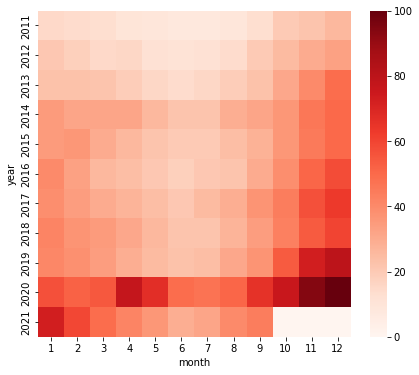

In [15]:
# create a heatmap to identify exceptional periods

plt.figure(figsize=(7, 6))
sns.heatmap(pivot.transpose(), cmap="Reds")

We observe seasonal peaks in every December, with search activity beginning to increase in October and November.

+ Either people tend to mentally prepare for the cold season by googling for snugly warm, but not too tight-fitting comfort garments, 3 months before the cold mid-winter months of January and February;

+ or piles of gift-wrapped sweatpants — sad to say — really do clutter the floor beneath the x-mas trees.


In the 2020 row of the heatmap, we can discern the moment when sweatpants went off the rails: in April-May 2020 and November/December 2020. These are the spikes which will become the focus of our analysis.


Let’s visualize the long-term trend. We take our pivot table, apply the aggregation function ‘mean’, and choose years as the ‘index’ in the pivot table; and then plot the year-over-year trend of the annual interest.

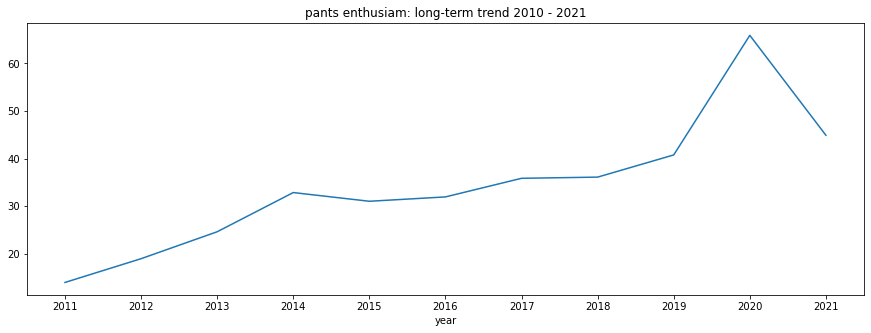

In [17]:
# visualize the long-term trend

year_avg = pd.pivot_table(df, values='Pants', index='year', aggfunc='mean')

year_avg['Pants'].plot(figsize=(15,5))
plt.title('pants enthusiam: long-term trend 2010 - 2021')
min_Y = df['year'].min()
max_Y = df['year'].max()
plt.xticks([x for x in range(max_Y, min_Y-1, -1)])
plt.show()

Karl Lagerfeld, the Parisian fashion tsar, might as well have exclaimed “Doom is nigh!” For 10 years or more, our civilization appears to have been on a trajectory to collectively lose control over our lives if Karl was right.


We reached peak pants bagginess, at least temporarily, in 2020, after an inexorable growth path since 2010.

Next, let’s investigate more closely the seasonality in our source data. We select month as the index in our pivot table and have the table compute the average value of each month across all years in our time series; and then plot the resulting 12-month curve.

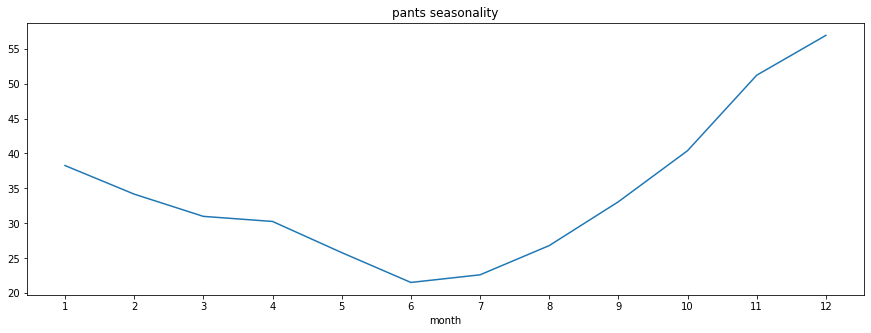

In [18]:
# visualize the seasonality

year_avg = pd.pivot_table(df, values='Pants', index='month', aggfunc='mean')

year_avg['Pants'].plot(figsize=(15,5))
plt.title('pants seasonality')
min_Y = df['month'].min()
max_Y = df['month'].max()
plt.xticks([x for x in range(max_Y, min_Y-1, -1)])
plt.show()

We observe a seasonal pants bagginess spike late in each fourth quarter. The chart indicates that every year, normally, tends to have a single trough in June/July, followed by a single peak in December.

To summarize, let’s decompose the time series into trend, seasonality, and residuals, and throw in the correlograms (ACF and PACF) as well, all in one function.

In [19]:
# define a decomposition function

def plot_decomp(y, lags):
   
    y = pd.Series(y)

    # decompose the time series into trend, seasonality and residuals
    decomp = sm.tsa.seasonal_decompose(y)
    trend = decomp.trend
    seas = decomp.seasonal
    resid = decomp.resid

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    
    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (0, 1))
    ax3 = plt.subplot2grid((3, 3), (1, 0))
    ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))

    y.plot(ax=ax1)
    ax1.set_title("Pants")

    trend.plot(ax=ax2)
    ax2.set_title("Trend")
    
    seas.plot(ax=ax3)
    ax3.set_title("Seasonality")

    resid.plot(ax=ax4)
    ax4.set_title("Residuals")

    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);

    plt.tight_layout()

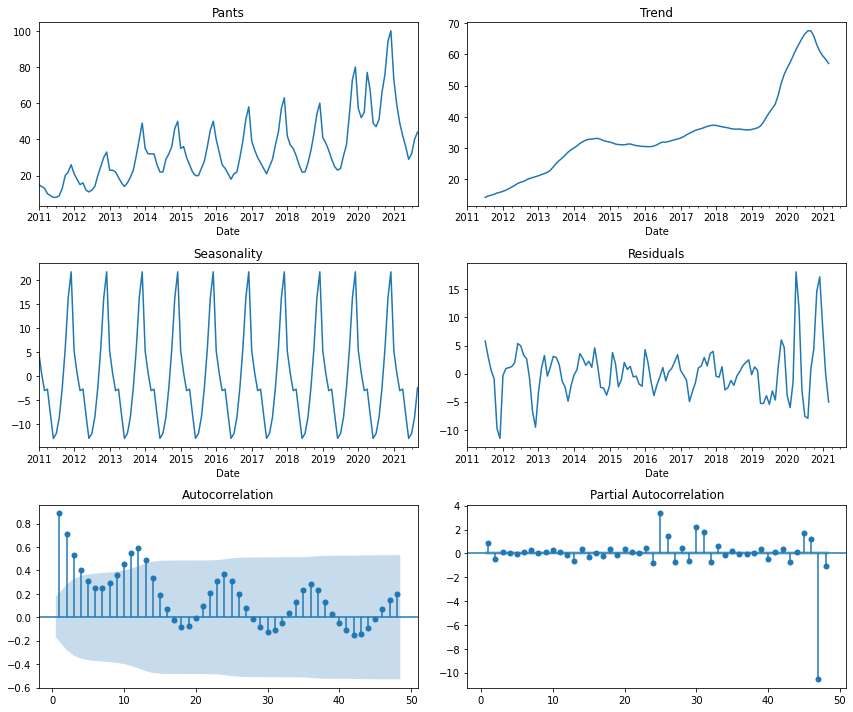

In [20]:
# call the decomposition function to plot the components

plot_decomp(y, 48)

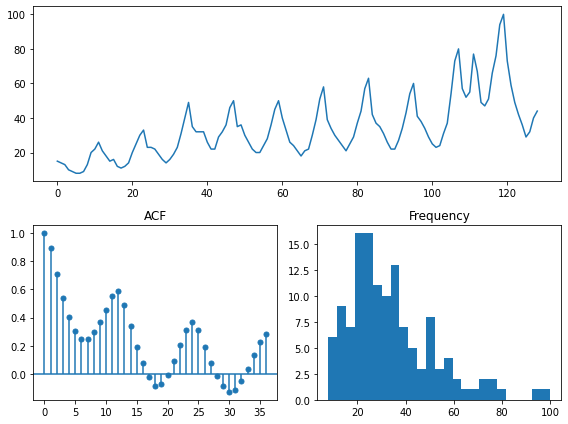

In [21]:
# histogram of observations below:
# not normally distributed
# trend indicated: no constant mean
# and funnel shape indicates heteroskedasticity. no constant variance

pmd.tsdisplay(y, lag_max=36)

The pmdarima package offers the tsdisplay method to visualize a time series. In addition to the charts we have created above, tsdisplay also shows a histogram of the observations (lower-right corner). Clearly, the observations are not normally distributed; they are left-skewed. The non-normality does not invalidate the SARIMA forecast model we want to develop. But normality would provide us with more reliable forecasts and confidence intervals.


Even more concerning is the funnel shape of the observations curve at the top. The widening funnel indicates that the variance is not time-invariant, which is mandatory for time series forecasts.

## 2. Diagnostics and Transformations

### 2.1 Homoskedasticity and Normality

The histogram shows observations that do not appear to be normally distributed. Let’s run the *normaltest* of scipy.stats.

In [23]:
# check the time series for normality - null hypothesis: normally distributed - rejected

normaltest(y)[1]

4.29013823083588e-07

The test confirms, with its vanishingly small p-value, that the original time series is not normally distributed.


So we have to sit down, in our fashionable black sweatpants, and ponder our next steps.

We decide to try out two transformations to solve both our issues, if possible: non-normality and — more urgently — heteroskedasticity (inconstant variance).

#### 2.1a Log-Transformation

First, we log-transform the observations.


The purpose of the transformation is to reshape the curve of observations in a way that narrows its expanding funnel (reduces its heteroskedasticity); and ideally also bends the curve so that it aligns more closely with normally distributed data, by adjusting the skewness and kurtosis of their distribution.


After fitting the forecast model, we will be able to inverse-transform the prediction values to make them comparable with the original, untransformed time series data.


The pmdarima package offers the LogEndogTransformer method.

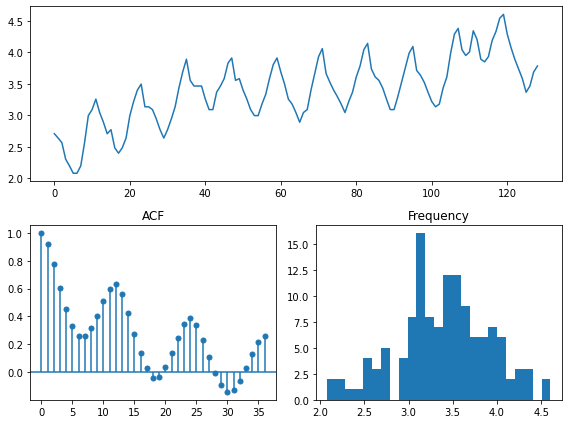

In [24]:
# apply a log transformation to try to get a time-invariant variance

y_log, _ = pmd.preprocessing.LogEndogTransformer(lmbda=1e-6).fit_transform(y)

pmd.tsdisplay(y_log, lag_max=36)

In [25]:
# check for normality after the log-transformation - success

normaltest(y_log)[1]

0.6049450648417378

The log-transformed line chart has lost most of its concerning funnel-shape. The variance seems to be time-invariant, too. The histogram resembles a normal distribution, without a significant skew to the left or right. The high p-value of the normality test confirms this.

#### 2.1b Box-Cox-Transformation

As an alternative to log-transformations, we run the Box-Cox transformer, which can often be more effective than log-transformations.

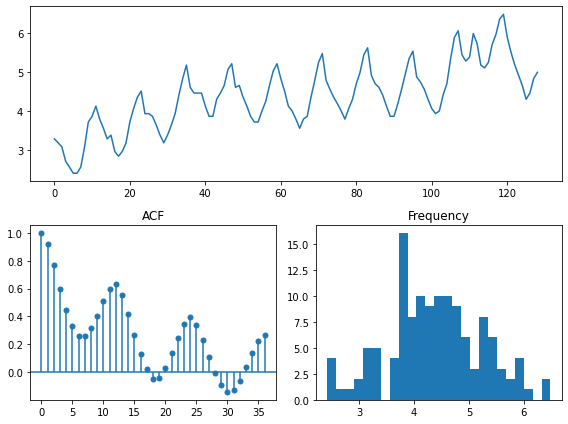

In [28]:
# try a Box-Cox transformation as an alternative

y_bc, _ = pmd.preprocessing.BoxCoxEndogTransformer(lmbda2=1.E-6).fit_transform(y)
pmd.tsdisplay(y_bc, lag_max=36)

In [29]:
# normality test: passing with flying colors

normaltest(y_bc)[1]

0.9777684420996898

The charts look similar to the log-transformed series. The normality test returns an even more favorable p-value.


We will continue with the Box-Cox-transformed series.

### 2.2 Autocorrelation Structure

Next, we investigate the correlogram of the Box-Cox-transformed series.

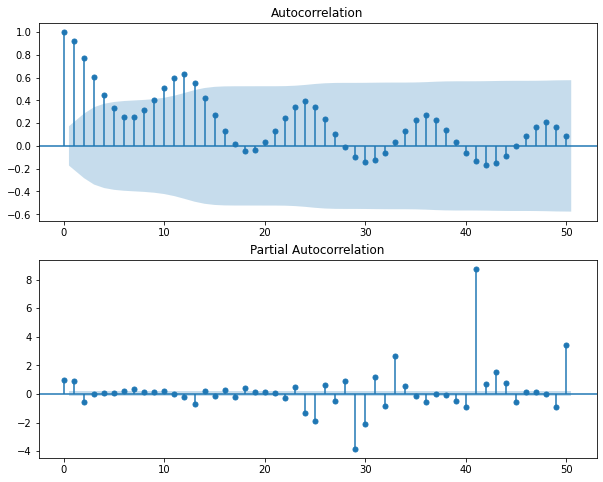

In [30]:
# define ACF and PACF function to check for autocorrelation structure
# visible seasonality

def plot_acf_pacf(y):
    N, M = 10, 8
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(N, M))

    acf_curve = plot_acf(y, alpha=ALPHA, lags=50, ax=ax1) 
    pacf_curve = plot_pacf(y, alpha=ALPHA, lags=50, ax=ax2) 
    

# correlogram before differencing but after transformation:
plot_acf_pacf(y_bc)

We see a seasonal pattern in the ACF. Thus, the time series is not stationary - yet.

### 2.3 Stationarity

A time series is stationary if its mean, variance, and autocorrelation structure do not change over time. If they are not time-invariant, the properties we use today to prepare a forecast would be different from the properties we would observe tomorrow. A process that is not stationary would elude our methods for using past observations to predict the future development. The time series itself does not need to remain a flat, constant line in past and future periods to be deemed stationary — but the patterns that determine its changes over time need to be stationary to make its future behavior predictable.

The time series needs to exhibit:
* time-invariant mean
* time-invariant variance
* time-invariant autocorrelations

#### Inconstant Mean

A series that shows a robust upward or downward trend does not have a constant mean. But if its data points tend to revert to the trendline after disturbances, the time series is *trend*-stationary. By *differencing* the time series — taking the difference between an observation y(t) and an earlier observation y(t-n) — we could obtain a stationary (mean-reverting) series of the *changes*.

A time series with *seasonality* will exhibit patterns that repeat after a constant number of periods: temperatures in January differ from those in July, but January temperatures will be at a similar level between years. *Seasonal differencing* takes the difference between an observation and its predecessor that is S lags removed, with S being the number of periods in a full season, like 12 months in a year or 7 days in a week.


If both the trend and the seasonal pattern are relatively time-invariant, the differenced time series (first-differenced with respect to the trend; and seasonally-differenced with respect to the seasonality) will have an approximately constant mean.

The required order of differencing is a parameter that should be determined in advance, before fitting a forecast model to the data. “It is important to note that these information criteria tend not to be good guides to selecting the appropriate order of differencing (d) of a model, but only for selecting the values of p and q. This is because the differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not comparable. So we need to use some other approach to choose d, and then we can use the AICc to select p and q.” (Hyndman, [8.6 Estimation and order selection | Forecasting: Principles and Practice (2nd ed) (otexts.com)](https://otexts.com/fpp2/arima-estimation.html)).


To find out if differencing is required, we can run four tests:
* Augmented Dickey-Fuller ADF for first-differencing
* Kwiatkowski-Phillips-Schmidt-Shin KPSS for first-differencing
* Osborn-Chui-Smith-Birchenhall OCSB for seasonal differencing
* Canova-Hansen CH for seasonal differencing

#### 2.3a First-Differencing

We use pmdarima’s ADF and KPSS tests to obtain the recommended order of first-differencing.

In [31]:
# obtain order of first and seasonal differencing recommended by ADF and KPSS tests

def diff_order(y):
    n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=6)
    n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=6)
    n_diff = max(n_adf, n_kpss)
    n_diffs = {"ADF":n_adf, "KPSS":n_kpss, "decision":n_diff} 
    return n_diffs


# call the tests to determine the order of differencing:
print("recommended order of first differencing:")
diff_order(y_bc)

recommended order of first differencing:


{'ADF': 0, 'KPSS': 1, 'decision': 1}

We get a contradiction. KPSS asks for 1 order of differencing, whereas ADF asks for 0.
* If the ADF test does not find a unit root, but the KPSS test does, the series is *difference*-stationary: it still requires differencing.
* Conversely, if the KPSS test had not found a unit root, but the ADF test had, the series would have been deemed *trend*-stationary: it would require differencing (or other transformations such as de-trending).
* In general: If the tests disagree, we need to take the *higher* of the two test results (variable *n_diff*) as the appropriate order of differencing. Only if both tests agree that the series is stationary, we can refrain from differencing.

#### 2.3b Seasonal Differencing

In [32]:
# define tests for order of seasonal differencing

def diffseas_order(y, m):
    n_ocsb = pmd.arima.OCSBTest(m=m).estimate_seasonal_differencing_term(y)
    n_ch = pmd.arima.CHTest(m=m).estimate_seasonal_differencing_term(y)
    ns_diff = max(n_ocsb, n_ch)
    ns_diffs = {"OCSB":n_ocsb, "CH":n_ch, "decision":ns_diff}
    return ns_diffs


# call tests for seasonal differencing
print("recommended order of seasonal differencing:")
diffseas_order(y_bc, MSEAS)

recommended order of seasonal differencing:


{'OCSB': 0, 'CH': 0, 'decision': 0}

We run the OCSB and CH tests for the Box-Cox-transformed series. Both tests agree that no seasonal differencing is required.

#### 2.3c Check After Transformations

We combine the test results for stationarity and compute a differenced time series.

In [33]:
# combine the recommendations for differencing and apply them to the Box-Cox transformed time series

df2 = df.copy()
df2["y_bc"] = y_bc.tolist()


def diff_order_apply(y, m):
    n_diff = diff_order(y).get("decision")
    ns_diff = diffseas_order(y, m).get("decision")

    if n_diff * ns_diff != 0:
        df2["y_bc_diff"] = df2["y_bc"].diff(n_diff).diff(ns_diff)
    elif n_diff + ns_diff != 0:
        df2["y_bc_diff"] = df2["y_bc"].diff(max(n_diff, ns_diff))
    else:
        df2["y_bc_diff"] = df2["y_bc"]

* Column “Pants” in our dataframe below contains the original Google Trends data on sweatpants popularity.
* Column “y_bc” contains the Box-Cox-transformed values.
* Column “y_bc_diff” shows the differenced and transformed values.

In [34]:
# compute the differenced series

diff_order_apply(y_bc, MSEAS)
df2.dropna(how="any", inplace=True)
y_bc_diff = df2["y_bc_diff"]
df2

,Date,Pants,year,month,y_bc,y_bc_diff
Date,,,,,,
2011-02-01,2011-02-01,14,2011,2,3.197615,-0.100615
2011-03-01,2011-03-01,13,2011,3,3.090627,-0.106988
2011-04-01,2011-04-01,10,2011,4,2.720723,-0.369904
2011-05-01,2011-05-01,9,2011,5,2.575989,-0.144735
2011-06-01,2011-06-01,8,2011,6,2.416716,-0.159272
...,...,...,...,...,...,...
2021-05-01,2021-05-01,36,2021,5,4.663799,-0.258406
2021-06-01,2021-06-01,29,2021,6,4.310683,-0.353116
2021-07-01,2021-07-01,32,2021,7,4.470111,0.159428


In [35]:
# check the differenced and transformed series for normality

normaltest(y_bc_diff)[1]

0.011131715840974117

Final round of diagnostics, now for the differenced data:
* The differenced data still pass the test for normality with a p-value higher than 0.05
* The stationarity tests do not insist on additional rounds of differencing

In [36]:
# check if the differenced series requires additional orders of differencing

print('recommended order of additional first differencing:')
diff_order(y_bc_diff)

recommended order of additional first differencing:


{'ADF': 0, 'KPSS': 0, 'decision': 0}

### 2.4 Split of Training and Test Dataset

We split the Google Trends observations into a training dataset and a test dataset. In the constant TESTP, we had reserved the final 24 months for testing.

In [37]:
# split dataset into training and test set

dtrain = df[:-TESTP].copy()
dtest = df[-TESTP:].copy()  

y_train = dtrain["Pants"]
y_test = dtest["Pants"]

## 3. SARIMA

### 3.1 Training: Auto-ARIMA Search for Hyperparameters

The AutoARIMA method of the pmdarima package runs a hyperparameter search for the autoregressive AR terms and moving-average MA terms in a SARIMA model.


We choose stepwise search, which uses an algorithm developed by Hyndman and Khandakar in 2008 [(Automatic Time Series Forecasting: the forecast Package for R (r-project.org)](https://cran.r-project.org/web/packages/forecast/vignettes/JSS2008.pdf)). This algorithm is much faster than a full-grid search because it avoids to process the nonsensical parameter tuples in the search space.


We formulate the input for the AutoARIMA method as a so-called pipeline. The pipeline consists of our Box-Cox transformation (but could comprise additional transformations if we wanted to include them). The pipeline syntax will enable us to inverse-transform the model results when we compute predictions.

In [39]:
# Training:
# run auto ARIMA hyperparameter search for the training dataset
# the procedure will apply the pipeline transformations to the original data:
# Box-Cox transformation and differencing

from pmdarima.pipeline import Pipeline

n_diff = diff_order(y).get("decision")
ns_diff = diffseas_order(y, MSEAS).get("decision") 

if n_diff == 0:
    booStat = True
else:
    booStat = False
    

pipe = Pipeline([
    ('boxcox', pmd.preprocessing.BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pmd.AutoARIMA(
                            d=n_diff, D=ns_diff, m=MSEAS, seasonal=True, stationary=booStat,
                            max_p=4,max_q=4,max_P=3,max_Q=3, max_d=2, max_D=1, max_order=5,
                            stepwise=True, alpha=ALPHA,
                            suppress_warnings=True, trace=True)
                            )])

pipe.fit(y_train)
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=66.131, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=225.247, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=159.305, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=223.424, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=86.483, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=67.661, Time=0.54 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=68.114, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=144.902, Time=0.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=91.613, Time=0.58 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=74.455, Time=0.57 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=69.457, Time=0.62 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=64.185, Time=0.20 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=162.81

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  105
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 -25.177
Date:                              Sun, 26 Sep 2021   AIC                             60.354
Time:                                      20:51:52   BIC                             73.576
Sample:                                           0   HQIC                            65.711
                                              - 105                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1176      0.090     -1.301      0.193      -0.295       0.060
ma.L2         -0.2245      0.095     -2.359      0.018      -0.411      -0.038
ar.S.L12       0.9946      0.007    149.125      0.000       0.982       1.008
ma.S.L12      -0.7015      0.142     -4.928      0.000      -0.981      -0.423
sigma2         0.0686      0.013      5.128      0.000       0.042       0.095
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.82   Prob(JB):                         0.42
Heteroskedasticity (H):               0.67   Skew:                             0.09
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The **model summary** shows excellent diagnostic results:
* The **Ljung-Box test** returns a very high p-value of 0.91. So the residuals represent *white noise*. They do not contain a signal that the SARIMA model failed to find and could have used to improve its forecast accuracy.
* The Jarque-Bera test for normality returns a very high p-value of 0.72. The skewness is close 0 and the kurtosis is close to 3, as they should be to resemble a standard normal distribution. Therefore, we conclude that the residuals are normally distributed. Forecast values and confidence intervals will be more reliable than in a case of residuals with dubious normality.
* The **Heteroskedasticity test** returns a very high p-value of 0.78. We conclude that the residuals have constant variance.
* Most of the **SARIMA parameters** have coefficients far from zero, so their influence is not negligible. The exception is the second seasonal AR term *ar.S.L24*, whose coefficient is close to 0, with a wide confidence interval that straddles zero. Its SAR term also shows a very high p-value. We conclude that this second SAR term should probably be skipped. It does not contribute much to the model.

### 3.2 Prediction Accuracy Metrics


We define some prediction accuracy metrics, which will enable us to compare the SARIMA model for the training dataset we have just prepared with the upcoming out-of-sample predictions.

We fill a dictionary with the formulas for:
* mean absolute error (MAE),
* the mean absolute percentage error (MAPE),
* the root mean square error (RMSE) and
* the correlation between the predicted values and observations

In [40]:
# define prediction accuracy metrics

def prediction_accuracy(y_hat, y_act):

    mae = np.mean(np.abs(y_hat - y_act))                                    # MAE
    mape = np.mean(np.abs(y_hat - y_act)/np.abs(y_act))                     # MAPE
  
    rmse = np.mean((y_hat - y_act)**2)**.5                                  # RMSE
    
    corr = np.corrcoef(y_hat, y_act)[0,1]                                   # correlation of prediction and actual

    return({'mae': mae, 
            'mape': mape, 
            'rmse':rmse, 
            'corr':corr})

### 3.3 Training: In-Sample Predictions

In [41]:
# compare predictions with actual observation in training set
# in-sample prediction: training dataset

y_hat_train, conf_int_train = pipe.predict_in_sample(
    return_conf_int=True, 
    alpha=ALPHA, 
    inverse_transform=True)

resid_train = y_hat_train - y_train

train_accuracy = prediction_accuracy(y_hat_train, y_train)
train_accuracy

{'mae': 2.1426497724709677,
 'mape': 0.08956178880196405,
 'rmse': 2.8708388664224853,
 'corr': 0.9721894887975585}

pmdarima’s *predict_in_sample method* applies the fitted SARIMA(0,1,1)x(3,0,0)(12) model to the months in our training period.


The parameter *inverse_transform* tells the method to provide the predicted values and their confidence intervals in a similar structure as the original time series: the predictions will not be reported as Box-Cox-transformed values.

The prediction accuracy for the training dataset is not too bad.


The auto-fitted SARIMA model has captured ca. 91.5% in the ups and downs of historical sweatpants popularity: the mean absolute percentage error MAPE amounts to 8.5% of discrepancy between predictions and actual values. The 8.5 % consist of random fluctuations for which the model could not extract a stable pattern.


The root mean squared error RMSE is the standard deviation of the residuals. RMSE tells how closely the predictions hug the curve of actual observations.


The (linear) correlation between predicted and actual values is 97%.

### 3.4 Testing: Predictions for Test Dataset

Next, we run the same SARIMA model for the 24 months in the test dataset.

In [42]:
# compute predictions for months in the test dataset and compare with actual observations
# prediction: test dataset

y_hat_test, conf_int_test = pipe.predict(
    n_periods=TESTP,
    return_conf_int=True, 
    alpha=ALPHA, 
    inverse_transform=True)

resid_test = y_hat_test - y_test

test_accuracy = prediction_accuracy(y_hat_test, y_test)
test_accuracy

{'mae': 18.027648149694922,
 'mape': 0.283455112766889,
 'rmse': 21.552186754272288,
 'corr': 0.7810161448330946}

We get a much worse prediction accuracy. MAPE now amounts to 23%. The correlation between predictions and actual observations has fallen from 97% to 78%.


So what is afflicting our SARIMA model in 2020–2021?


Large disparities in prediction accuracy between training and test dataset usually imply *overfitting*.


* A model that is *underfit* will exhibit low accuracy both in the training dataset to which it was fitted, and the test dataset.
* A model that is *overfit* will present high accuracy in the training dataset, but deals poorly with new data such as in the test dataset.


In our case of *Sweatpants Unleashed*, the patterns the time series had followed over the preceding 10 years were no longer applicable once the Work-from-Home months started in April 2020. This implies an overfit model, but the overfit was inevitable because the 2020 disruptions could not be isolated as a predictable pattern from the historical 2010–2019 data in the training dataset.

### 3.5 The Pattern of the Past No Longer Hold in 2020

Let’s revisit the heatmap we had created in our source data investigation. We observe that 2020 was an exceptional year,
* with an unusual, “unseasonal” spike in Googling for sweatpants in April- May 2020;
* and another peak in November/December 2020, which was more similar to the seasonal patterns in previous years, but surged to a *much* higher amplitude as a hot fashion item than in previous winter seasons.


We can’t distill the reasons from the Google Trends data alone. But this pattern in 2020 suggests that interest in sweatpants shot up in April when many people had to huddle around the warming glow of their notebook screens at home rather than continuing with their morning and evening commutes to their workplaces. Evidently, most of us chose not to wear formal office attire while typing away on our keyboards at the kitchen table.


In November — December 2020, we observe a higher than usual amplitude of sweatpants acclaim supposedly because Covid-19 cases were rising fast in the months before vaccines became available in early 2021. In the fall of 2020, People might have expected to have to withdraw into their home caves for a long, dire winter.


Out of our data science toolbox, we could pull the test kit for *cointegration* & *granger causality* [(Granger Causality Tyrion Cersei | Towards Data Science)](https://towardsdatascience.com/sibling-rivalry-and-cointegration-in-the-game-of-thrones-8642466fa2f2). If we compared the intensity of *work-from-home* and the *sweatpants* popularity in 2020, I’d expect to see some considerable Granger causality.

What’s our next step?


Let’s investigate how badly the sudden rise of *work-from-home* has derailed the time series pattern that had been valid throughout the preceding decade.

## 4. Predictable Trend versus Trend-Break in 2020

### 4.1 Training SARIMA Model Up To The Break Point

From our Google Trends raw data 2010–2021, we slice off a training dataset that ends in March 2020, just before lockdowns and work-from-home routines established a new reality.


We fit a new SARIMA model to this training dataset that represents the old normal.

In [43]:
# define a training dataset that excludes the unusual work-from-home months since April 2020

boomaskTrain = df["Date"] < dt.datetime(2020,4,1)
boomaskTest = df["Date"] >= dt.datetime(2020,4,1)

dtrain2 = df[boomaskTrain].copy()
dtest2 = df[boomaskTest].copy()  

y_train2 = dtrain2["Pants"]
y_test2 = dtest2["Pants"]


final_month = dtest2["Date"][-1:,][0]

In [44]:
# Training 2:
# auto ARIMA for training dataset excluding work-from-home months
# the procedure will apply the pipeline transformations to the original data:
# Box-Cox transformation and differencing

pipe = Pipeline([
    ('boxcox', pmd.preprocessing.BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pmd.AutoARIMA(
                            d=n_diff, D=ns_diff, m=MSEAS, seasonal=True, stationary=booStat,
                            max_p=4,max_q=4,max_P=3,max_Q=3, max_d=2, max_D=1, max_order=5,
                            stepwise=True, alpha=ALPHA,
                            suppress_warnings=True, trace=True)
                            )])

pipe.fit(y_train2)
pipe.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-30.285, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=134.967, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=63.713, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=133.353, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-8.824, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-27.711, Time=0.61 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-29.129, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1.192, Time=0.58 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-20.675, Time=0.51 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-32.379, Time=0.21 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=67.049, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  111
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                  21.453
Date:                              Sun, 26 Sep 2021   AIC                            -36.905
Time:                                      21:08:08   BIC                            -28.804
Sample:                                           0   HQIC                           -33.619
                                              - 111                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9969      0.007    149.212      0.000       0.984       1.010
ma.S.L12      -0.8076      0.185     -4.377      0.000      -1.169      -0.446
sigma2         0.0291      0.006      5.206      0.000       0.018       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.42   Prob(JB):                         0.58
Heteroskedasticity (H):               0.70   Skew:                             0.15
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Training: prediction vs actual observations for years and months prior to April 2020
# in-sample prediction: training dataset

y_hat_train2, conf_int_train2 = pipe.predict_in_sample(
    return_conf_int=True, 
    alpha=ALPHA, 
    inverse_transform=True)

resid_train2 = y_hat_train2 - y_train2

train_accuracy2 = prediction_accuracy(y_hat_train2, y_train2)
train_accuracy2

{'mae': 2.251346105471199,
 'mape': 0.08660586026106885,
 'rmse': 3.062784774040528,
 'corr': 0.9767014064968909}

Then we run predictions for the months since April 2020.

The new training model returns the predictions for sweatpants popularity until March 2020.

### 4.2 Testing the SARIMA Model After the Break Point of April 2020

Let’s see how sweatpants would have fared in an alternative universe that was not afflicted by Covid-19 after March 2020.

In [47]:
# Testing:
# forecast out of sample for months since April 2020

TESTP2 = len(dtest2)

y_hat_test2, conf_int_test2 = pipe.predict(
    n_periods=TESTP2,
    return_conf_int=True, 
    alpha=ALPHA, 
    inverse_transform=True)

resid_test2 = y_hat_test2 - y_test2

test_accuracy2 = prediction_accuracy(y_hat_test2, y_test2)
test_accuracy2

{'mae': 11.897512814215666,
 'mape': 0.25726805610919745,
 'rmse': 14.364238104987374,
 'corr': 0.7143588500127785}

As expected, the prediction accuracy is quite bad, illustrating that the Covid disruption put the baggy pants trend on a very different, unforeseen path from April 2020.

### 4.3 The Unforeseen “Work-From-Home” Impact Since April 2020

To discern the magnitude of the Covid-19 impact on the sweatpants fashion corner, let’s compare the predictions for the months after April 2020 in that alternative universe with what happened in our universe.

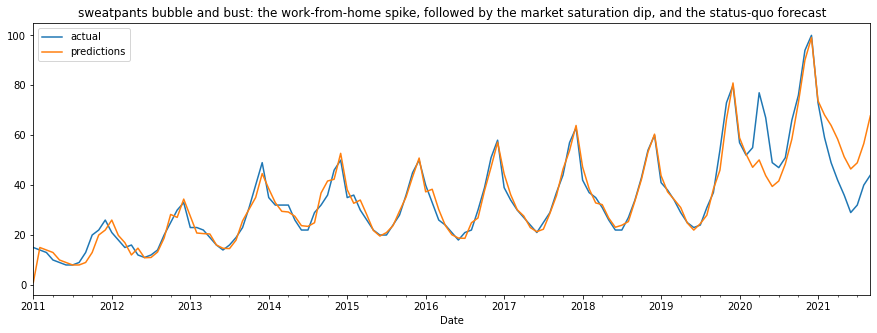

In [48]:
# plot the actual observations since 2011 and the predicted values
# see the status quo forecast trend 2020/04 - 2021/09 - if the disruptions of 2020 had not disrupted the long-term pattern

# combine numpy arrary with predicted and actual values
yhat2 = np.hstack((y_hat_train2, y_hat_test2))
y_yhat = np.vstack((y, yhat2))

dfwif = df.copy()
# dfwif = pd.DataFrame(y_yhat[0], columns=["actual"])
dfwif["actual"] = y_yhat[0].tolist()
dfwif["predictions"] = y_yhat[1].tolist()
dfwif


# from dateutil.relativedelta import relativedelta
# len_hist = len(dfwif)
# final_month = pd.to_datetime(final_month)
# first_month = final_month - relativedelta(months=len_hist)
# plt.xticks[first_month: final_month]

dfwif[["actual", "predictions"]].plot(figsize=(15,5))
plt.title('sweatpants bubble and bust: the work-from-home spike, followed by the market saturation dip, and the status-quo forecast')
plt.show()

* We see how closely the SARIMA predictions (orange) are hugging the actual observations (blue) between 2011 and the first quarter of 2020.
* Early in the second quarter of 2020, sweatpants show a sudden additional blue spike that had never before occurred in any seasonal pattern. The unanticipated April/May spike causes most of the inaccuracy that our prediction metrics report.
* The SARIMA model does anticipate the peak in November + December 2020.
* Yet the model did not foresee that sweatpants would experience a sudden decline in popularity in 2021, immediately after the turn of the year; and even before many work-from-home arrangements were reversed.
* We can surmise that households had stocked up their strategic sweatpants reserves in the course of 2020. By January 2021, they were well provisioned with loose legwear for the next 2 or 3 years. So the search for sweatpants lost its urgency in 2021.
* On the boom of the sweatpants industry in 2020 followed a bust in early 2021.

A next step could be an intervention analysis that isolates the work-from-home impact, for instance by defining it as an exogenous variable.


But we won’t do that today. Rather, we will put our loosely-clothed legs up and take a nap.

In [1]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: /Users/horst/.vscode/extensions/ms-toolsai.jupyter-2021.9.1101343141/pythonFiles:/Users/horst/.vscode/extensions/ms-toolsai.jupyter-2021.9.1101343141/pythonFiles/lib/python
PATH: /usr/local/Caskroom/miniconda/base/envs/mach_lern2/bin:/usr/local/Caskroom/miniconda/base/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/Apple/usr/bin
